N individuos : 

S susceptiveis

I infectados nao hospitalizados

H infectados hospitalizados 

R recuperados


- Taxa media de novos contagios $rI(t) = \beta(t) * (I(t) + H(t)) * S(t) / N$
em media 5% dos infectados sao $H \beta(t) = \beta(0) = 0.2592$

- 2 dias por mes são excepcionais;

- Nos dias excepcionais $\beta(t) = 3 * \beta(0)$

- Taxa media de recuperacao dos infectados nao hospitalizados $(I)$ eh $r_{RI}(t) =  \gamma_i I(t), 
( γ _i = 0.07143/dia)$ (duracao media da doenca ~= duas semanas)

- Taxa media de recuperacao dos infectados hospitalizados $(H)$ eh $r_{RH}(t) =  \gamma_i H(t)$, 
com $\gamma_i = 0.03571/dia$ (duracao media da doenca ~= quatro semanas)


_____________________________________________________________________________________
SIMULACAO 

N = $10^4$

$I(0)$ = rand(10, 20)

$H(0)$ = 0

$t$ ate nao haver mais pessoas hostpitalizadas por 3 dias seguidos

Queremos salvar as variaveis
- $X = max_t H(t)$
- O tempo T*, desde a primeira hospitalizacao ate o pico maximo de hospitalizados
- a fracao da populacao que teve a doenca uma vez acabada a epidemia. A fracao que esteve hospitalizada
- O tempo desde a primeira hospitalizacao ate a hospitalizacao numero 10, e ate a hopitalizacao 40 ($T_10$ e $T_40$))




O que descobrimos:


- $\beta$ é influenciado por $t$ da seguinte maneira:
A cada passagem de t, existe uma chance de $\frac{1}{15}$ de ser um dia especial, se for o caso, $\beta = 3 * \beta_0$
- Não esquecer q o número de recuperados não ode ser maior q o de novos infectados

In [1]:
import random
import numpy as np

In [2]:
def compare_sign(effective, received):
  for sign in received:
    if not effective.get(sign):
      continue
    if effective[sign][-1] != received[sign][-1]:
      return False
  return True

In [3]:
class SimulateEpidemic:

  def __init__(self, s, i=0, h=0, r=0):
      self.susceptible, self.infected, self.hospitalized, self.recovered = ([s], [i], [h], [r])
      self.population_size = s + i + h + r

  curr_time = 1
  beta_zero = 0.2592
  avg_hospitalized = 0.05

  @property
  def keys(self):
    return {"susceptible": self.susceptible, "infected": self.infected,
            "hospitalized": self.hospitalized, "recovered": self.recovered}

  @property
  def beta(self):
    return self.beta_zero * (3 if random.random() <= 1/15 else 1)

  @property
  def last_time(self):
    return self.curr_time - 1

  def last(self, variable):
    return variable[self.last_time]

  def update(self, variable, increment, is_new=True):
    new = self.last(variable) + increment
    if is_new:
      variable.append(new)
    else:
      variable[self.curr_time] += increment

  def run(self, t, stop_sign=None, is_random=True):

    min_count = False
    func = (np.random.poisson if is_random else int)

    while (t > 0 or stop_sign["t"] > 0) or not min_count:
      new_contagions = self.new_contagions()
      new_contagions = list(map(func,
                           [new_contagions * self.avg_hospitalized, new_contagions * (1 - self.avg_hospitalized)]))
      recoveries = list(map(func,
                       [self.avg_recovery(is_hospitalized=True), self.avg_recovery()]))

      self.update(self.recovered, sum(recoveries))
      self.update(self.susceptible, -sum(new_contagions))

      self.update(self.hospitalized, new_contagions[0])
      self.update(self.hospitalized, -recoveries[0], False)

      self.update(self.infected, new_contagions[1])
      self.update(self.infected, -recoveries[1], False)

      stop_sign["t"] = (stop_sign["t"] - 1 if compare_sign(self.keys, stop_sign) else stop_sign["latent_t"])
      if new_contagions[0] != 0:
        min_count = True

      self.curr_time += 1
      t -= 1

  def avg_recovery(self, is_hospitalized=False):
    if is_hospitalized:
      return 0.03751 * self.last(self.hospitalized)
    else:
      return 0.07143 * self.last(self.infected)

  def new_contagions(self):
    return self.beta * (self.last(self.infected) + self.last(self.hospitalized)) * self.last(self.susceptible) / self.population_size

In [4]:
infected = random.randint(10, 20)
simulation = SimulateEpidemic(10**4, i=infected)
simulation.run(0, stop_sign={"hospitalized": [0], "latent_t": 3, "t": 3})

In [5]:
import pandas as pd

In [6]:
df = pd.DataFrame.from_dict(simulation.keys)

In [7]:
df

,susceptible,infected,hospitalized,recovered
0,10000,17,0,0
1,9994,20,0,3
2,9986,24,0,7
3,9981,28,0,8
4,9977,32,0,8
...,...,...,...,...
209,90,0,1,9926
210,90,0,1,9926
211,90,0,0,9927
212,90,0,0,9927


In [8]:
sum(df.iloc[0]) == sum(df.iloc[-1])

True

In [9]:
import seaborn as sns
sns.set()

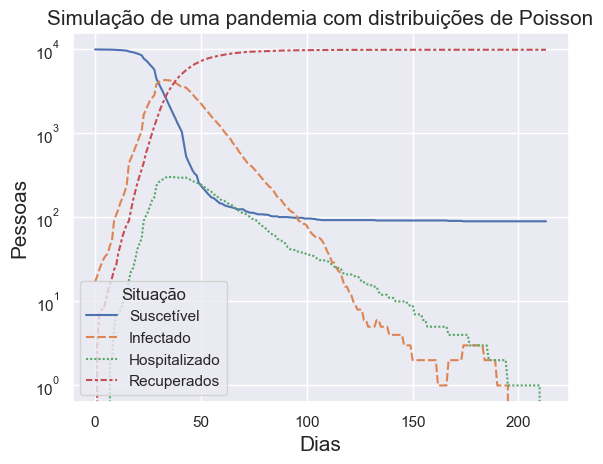

In [10]:
graph = sns.lineplot(data=df)
graph.axes.set_title("Simulação de uma pandemia com distribuições de Poisson", fontsize=15)
graph.set_xlabel("Dias", fontsize=15)
graph.set(yscale='log')
graph.set_ylabel("Pessoas", fontsize=15)
graph.legend(title='Situação', labels=['Suscetível', 'Infectado', "Hospitalizado", "Recuperados"])